## はじめる前に

### 注意すべきバイアス
・Lookahead Bias
過去の価格データだけでなく「未来のデータ」を誤って利用してしまうこと。

## 初期設定

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np

# データ読み込み
df = pd.read_csv("btc_jpy-1min-20250501_20251101.csv", index_col=0, parse_dates=True)

## テクニカル指標

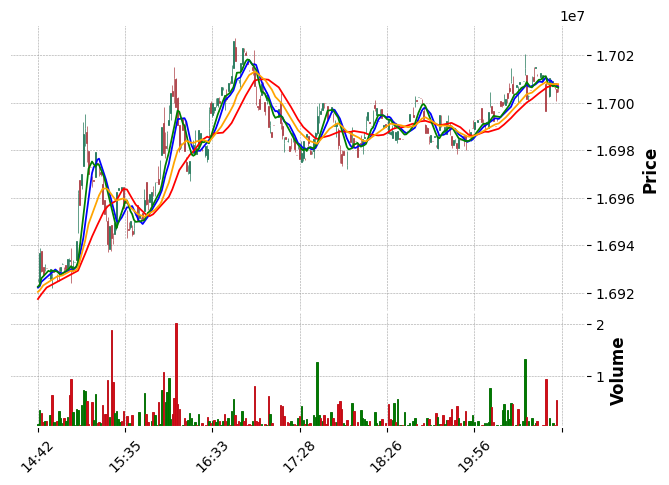

In [3]:
# numpy化
fre1_close_array = df["close"].to_numpy()
fre1_high_array = df['high'].to_numpy()
fre1_low_array = df['low'].to_numpy()

# 単純移動平均(SMA)
def SMA(data,term):
  weight = np.ones(term)
  res = np.zeros(len(data)-term)
  for i in range(len(data)-term):
    res[i] = (data[i:i+term]*weight).sum()/weight.sum()
  return np.concatenate([np.zeros(term),res])

# 加重移動平均(WMA)
def WMA(data,term):
  weight = np.arange(1,term+1)
  res = np.zeros(len(data)-term)
  for i in range(len(data)-term):
    res[i] = (data[i:i+term]*weight).sum()/weight.sum()
  return np.concatenate([np.zeros(term),res])

# 指標計算(ゴールデンクロス・デッドクロス)
SMA_short = SMA(fre1_close_array,9)
SMA_long = SMA(fre1_close_array,26)
WMA_short = WMA(fre1_close_array,9)
WMA_long = WMA(fre1_close_array,26)

# 表示
start_term = -300
end_term = -1
df["SMA_short"] = SMA_short
df["SMA_long"] = SMA_long
df["WMA_short"] = WMA_short
df["WMA_long"] = WMA_long

add_plots = [
    mpf.make_addplot(df["SMA_short"][start_term:end_term], color='blue'),
    mpf.make_addplot(df["SMA_long"][start_term:end_term], color='red'),
    mpf.make_addplot(df["WMA_short"][start_term:end_term], color='green'),
    mpf.make_addplot(df["WMA_long"][start_term:end_term], color='orange'),
]

mpf.plot(
    df[["open","high","low","close","volume"]][start_term:end_term],
    type='candle',
    volume=True,
    style='charles',
    addplot=add_plots
)


plt.show()

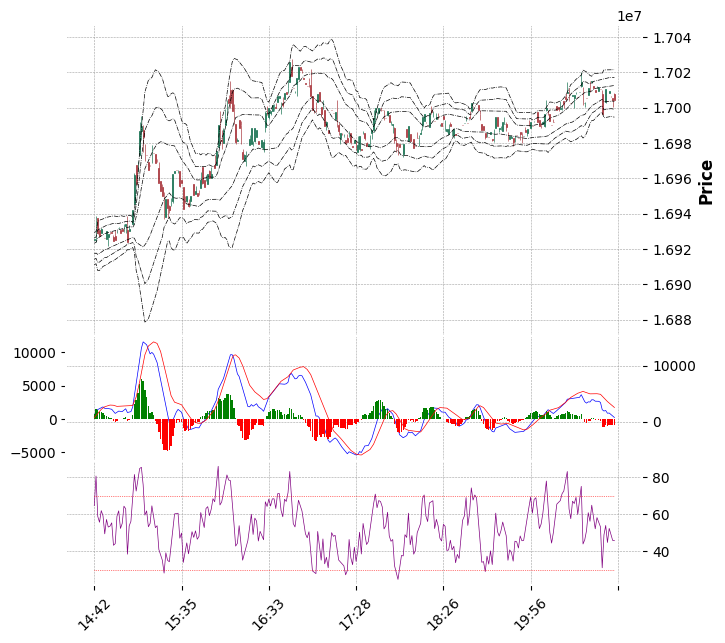

In [6]:
# 指数移動平均(EMA)
def EMA(data,term):
    alpha = 2 / (term + 1)
    ema = np.zeros(len(data))
    ema[0] = data[0]
    for i in range(1, len(data)):
        ema[i] = alpha * data[i] + (1 - alpha) * ema[i - 1]
    return ema

# MACD
def MACD(data,short_term,long_term,signal_term):
    EMA_short = EMA(data,short_term)
    EMA_long = EMA(data,long_term)
    MACD_line = EMA_short - EMA_long
    signal_line = EMA(MACD_line,signal_term)
    histgram = MACD_line - signal_line
    return MACD_line, signal_line, histgram

# ボリンジャーバンド(BB)
def BB(data,term,num_std):
  sma = SMA(data,term)
  res_std = np.zeros(len(data))
  for i in range(len(data)-term):
    res_std[i+term] = data[i:i+term].std()
  upper_band = sma + num_std * res_std
  lower_band = sma - num_std * res_std
  return upper_band, lower_band

# RSI
def RSI(data,term):
  delta = np.concatenate([np.zeros(1), data[1:] - data[:-1]])
  gain = np.where(delta > 0, delta, np.zeros_like(delta))
  loss = np.where(delta < 0, -delta, np.zeros_like(delta))
  avg_gain = EMA(gain, term)
  avg_loss = EMA(loss, term)
  rs = avg_gain / (avg_loss + 1e-10)
  rsi = 100 - (100 / (1 + rs))
  return rsi

# 指標計算
macd,signal,histgram = MACD(fre1_close_array,12,26,9)
upper_band1, lower_band1 = BB(fre1_close_array,20,1)
upper_band2, lower_band2 = BB(fre1_close_array,20,2)
upper_band3, lower_band3 = BB(fre1_close_array,20,3)
rsi = RSI(fre1_close_array,14)

# 表示
start_term = -300
end_term = -1

# ==== 指標を DataFrame 化 ====
df["MACD"] = macd
df["Signal"] = signal
df["Histgram_upper"] = np.where(histgram>0, histgram, 0)
df["Histgram_lower"] = np.where(histgram<0, histgram, 0)
df["Upper_Band1"] = upper_band1
df["Lower_Band1"] = lower_band1
df["Upper_Band2"] = upper_band2
df["Lower_Band2"] = lower_band2
df["Upper_Band3"] = upper_band3
df["Lower_Band3"] = lower_band3
df["RSI"] = rsi

add_plots = [
    mpf.make_addplot(df["Upper_Band1"][start_term:end_term], panel=0, color='black', linestyle='dashdot', width=0.5),
    mpf.make_addplot(df["Lower_Band1"][start_term:end_term], panel=0, color='black', linestyle='dashdot', width=0.5),
    mpf.make_addplot(df["Upper_Band2"][start_term:end_term], panel=0, color='black', linestyle='dashdot', width=0.5),
    mpf.make_addplot(df["Lower_Band2"][start_term:end_term], panel=0, color='black', linestyle='dashdot', width=0.5),
    mpf.make_addplot(df["Upper_Band3"][start_term:end_term], panel=0, color='black', linestyle='dashdot', width=0.5),
    mpf.make_addplot(df["Lower_Band3"][start_term:end_term], panel=0, color='black', linestyle='dashdot', width=0.5),
    mpf.make_addplot(df["MACD"][start_term:end_term], panel=1, color='blue', width=0.5),
    mpf.make_addplot(df["Signal"][start_term:end_term], panel=1, color='red', width=0.5),
    mpf.make_addplot(df["Histgram_upper"][start_term:end_term], panel=1, type='bar', color='green'),
    mpf.make_addplot(df["Histgram_lower"][start_term:end_term], panel=1, type='bar', color='red'),
    mpf.make_addplot(df["RSI"][start_term:end_term], panel=2, color='purple', width=0.5),
    mpf.make_addplot([30 for _ in range(len(df[start_term:end_term]))], panel=2, color='red', linestyle='dotted', width=0.5),
    mpf.make_addplot([70 for _ in range(len(df[start_term:end_term]))], panel=2, color='red', linestyle='dotted', width=0.5),
]

mpf.plot(
    df[["open","high","low","close","volume"]][start_term:end_term],
    type='candle',
    volume=False,
    style='charles',
    addplot=add_plots,
    figsize=(8,8)
)

plt.show()

## 決済逆算

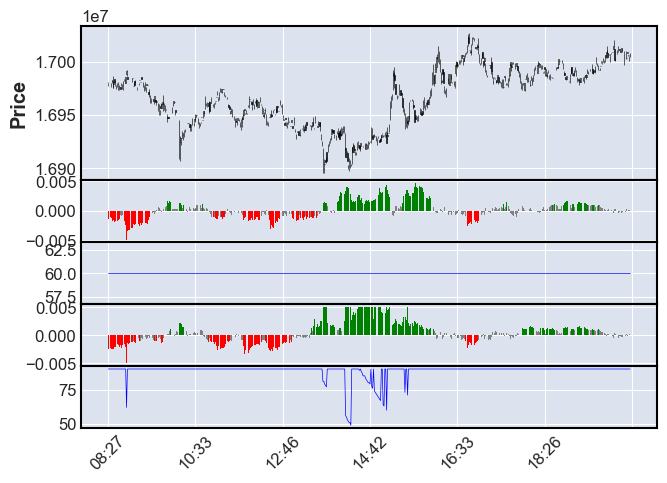

In [13]:
# データ読み込み
df = pd.read_csv("btc_jpy-1min-20250501_20251101.csv", index_col=0, parse_dates=True)

# torchテンソル化
fre1_close_tensor = df["close"].to_numpy()
fre1_high_tensor = df['high'].to_numpy()
fre1_low_tensor = df['low'].to_numpy()

# トリプルバリアの決済逆算関数
def triple_barrier_exit(close, high, low, upper_rate, lower_rate, holding_period):
    n = len(close)
    diff = np.zeros(n)
    hold_times = np.full((n,), holding_period)
    exit_times = np.arange(n)
    for start_idx in range(n):
        offset_high = high[start_idx:start_idx+holding_period]
        offset_low = low[start_idx:start_idx+holding_period]
        res = np.where(offset_high/close[start_idx] >= upper_rate, 1,np.where(offset_low/close[start_idx] <= lower_rate, -1, 0))
        hit_indices = np.nonzero(res)[0]
        if len(hit_indices) > 0:
            hold_times[start_idx] = hit_indices[0].item() + 1
            exit_times[start_idx] = start_idx + hit_indices[0].item()
            if res[hit_indices[0]] == 1:
                diff[start_idx] = upper_rate-1
            elif res[hit_indices[0]] == -1:
                diff[start_idx] = lower_rate-1
        else:
            hold_times[start_idx] = holding_period
            exit_times[start_idx] = min(start_idx + holding_period, n - 1)
            diff[start_idx] = (close[exit_times[start_idx]] - close[start_idx]) / close[start_idx]
        
    return diff, hold_times, exit_times

# 決済逆算
#==================================
diff1, hold_times1, exit_times1 = triple_barrier_exit(
    fre1_close_array,
    fre1_high_array,
    fre1_low_array,
    upper_rate=1.01,
    lower_rate=0.99,
    holding_period=60,
)

slippage1 = 0.001
long_gains1 = np.where(diff1 > slippage1, diff1, 0)
loss1 = np.where((diff1 < slippage1) & (diff1 > -slippage1), diff1, 0)
short_gains1 = np.where(diff1 < -slippage1, diff1, 0)

#==================================
diff2, hold_times2, exit_times2 = triple_barrier_exit(
    fre1_close_tensor,
    fre1_high_tensor,
    fre1_low_tensor,
    upper_rate=1.005,
    lower_rate=0.995,
    holding_period=90,
)

slippage2 = 0.001
long_gains2 = np.where(diff2 > slippage2, diff2, 0)
loss2 = np.where((diff2 < slippage2) & (diff2 > -slippage2), diff2, 0)
short_gains2 = np.where(diff2 < -slippage2, diff2, 0)
#==================================

# 表示
start_term = -600
end_term = -1

df["long_gains1"] = long_gains1
df["loss1"] = loss1
df["short_gains1"] = short_gains1
df["Hold_Times1"] = hold_times1
df["long_gains2"] = long_gains2
df["loss2"] = loss2
df["short_gains2"] = short_gains2
df["Hold_Times2"] = hold_times2

add_plots = [
    mpf.make_addplot(df["long_gains1"][start_term:end_term], panel=1, color='green',type='bar'),
    mpf.make_addplot(df["loss1"][start_term:end_term], panel=1, color='gray',type='bar'),
    mpf.make_addplot(df["short_gains1"][start_term:end_term], panel=1, color='red',type='bar'),
    mpf.make_addplot(df["Hold_Times1"][start_term:end_term], panel=2, color='blue', width=0.5),
    mpf.make_addplot(df["long_gains2"][start_term:end_term], panel=3, color='green',type='bar'),
    mpf.make_addplot(df["loss2"][start_term:end_term], panel=3, color='gray', type='bar'),
    mpf.make_addplot(df["short_gains2"][start_term:end_term], panel=3, color='red', type='bar'),
    mpf.make_addplot(df["Hold_Times2"][start_term:end_term], panel=4, color='blue', width=0.5),
]

mpf.plot(
    df[["open","high","low","close","volume"]][start_term:end_term],
    addplot=add_plots,
    type='candle',
    volume=False,
)